# AI-driven morphoclimatic regional frequency modelling of sub-daily rainfall-extremes
**Authors**: Chiara Angileri, Niccolò Marzi, Shola Oshodi

## 0. Importing libraries

In [1]:
colab = False

if colab:
    !pip install fitter
    !pip install pydot
    !pip install graphviz
    from pathlib import Path
    from google.colab import drive
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
from itertools import chain
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy import stats

from utils import util

C:\Users\chiar\AppData\Local\Temp\ipykernel_10144\2575568485.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from importlib import reload  
from utils import util
util = reload(util)

In [48]:
# Set random seed for reproducibility
def fix_random_seed(seed=24):
    np.random.seed(seed)
    tf.random.set_seed(seed)

fix_random_seed()

## 1. Load and inspect the dataset

### 1.1. Load data

In [49]:
df, df_indexes_test = util.load_data(colab)
print(df.columns)

Index(['ID', 'Nome', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y', 'duration[h]', 'AMS',
       'mean_IdD', 'loc', 'scale', '99perc', '95perc', '80perc'],
      dtype='object')


In [50]:
df.head()

,ID,Nome,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),...,X,Y,duration[h],AMS,mean_IdD,loc,scale,99perc,95perc,80perc
0,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,1.221239,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
1,5001,'Abetone',1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.037400,377.648461,...,633069.81,4890553.68,1,0.778761,28.250000,0.890564,0.184415,1.738901,1.438313,1.167176
2,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.219018,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
3,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,0.979995,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679
4,5002,'Albareto',531.112211,40.321631,7.545648,4.469855,219.061317,121.198571,203.680776,300.679959,...,555576.92,4921743.21,1,1.153287,33.469565,0.823918,0.287186,2.145015,1.676915,1.254679


### 1.2. Preprocess and split the dataset

In [51]:
# Clean the dataset from the columns that are not useful
to_remove = ['Nome', '99perc', '95perc', '80perc']
df = df.drop(to_remove, axis=1, inplace=False)

# Unique duration values
DURATION = df['duration[h]'].unique()
print('Durations: ', DURATION)

Durations:  [ 1  3  6 12 24]


#### 1.2.1 Split the dataset into train, validation and test

In [52]:
# Take the first 100 ID and use them to create the test sets
test_ID = df_indexes_test['ID'].to_list()[:100]

test_df = df[df['ID'].isin(test_ID)]
test_df.reset_index(drop=True, inplace=True)

# Drop the test set from df and then create the train sets and validation sets
df = df.drop(df[df['ID'].isin(test_ID)].index)
df.reset_index(drop=True, inplace=True)

validation_split = 0.1
df = df.sort_values(by=['ID'])

train_df, val_df = train_test_split(df, test_size=validation_split, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [53]:
train_df.head()

,ID,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h],AMS,mean_IdD,loc,scale
0,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,1,1.221239,28.250,0.890564,0.184415
1,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.680425,199.875,0.859361,0.219803
2,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.855535,199.875,0.859361,0.219803
3,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,0.945591,199.875,0.859361,0.219803
4,5001,1319.144154,85.599127,13.342638,4.979222,252.769653,96.036924,134.0374,377.648461,426.348085,...,577.581116,484.327515,281.33847,633069.81,4890553.68,24,1.518449,199.875,0.859361,0.219803


#### 1.2.2 Standardize datasets

In [54]:
train_df_std = util.standardize(train_df, 'gumbel')
val_df_std = util.standardize(val_df, 'gumbel')
test_df_std = util.standardize(test_df, 'gumbel')

In [55]:
# column ID must be integer
train_df_std['ID'] = train_df_std['ID'].astype(int)
val_df_std['ID'] = val_df_std['ID'].astype(int)
test_df_std['ID'] = test_df_std['ID'].astype(int)

# column duration[h] must be integer
train_df_std['duration[h]'] = train_df_std['duration[h]'].astype(int)
val_df_std['duration[h]'] = val_df_std['duration[h]'].astype(int)
test_df_std['duration[h]'] = test_df_std['duration[h]'].astype(int)

In [56]:
train_df_std.head()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
0,5001,1.221239,28.250,0.890564,0.184415,1,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
1,5001,0.680425,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
2,5001,0.855535,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
3,5001,0.945591,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267
4,5001,1.518449,199.875,0.859361,0.219803,24,1.491097,0.251105,0.104265,-0.433165,...,-0.79254,1.031064,1.012611,0.623256,2.169919,4.627821,1.780453,4.58539,0.512238,-0.713267


In [57]:
train_df_std.describe()

,ID,AMS,mean_IdD,loc,scale,duration[h],HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),...,MinDistTirrenicC_(km),OrograTirr_mean(m),OrograTirr_stdev(m),OrograTirr_max(m),MAP(mm),MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y
count,233218.000000,233218.000000,233218.000000,233218.000000,2.332180e+05,233218.000000,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,...,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05,2.332180e+05
mean,11047.209328,0.999994,57.052651,0.840404,2.670913e-01,9.199200,7.507042e-17,7.409548e-17,-3.314798e-17,3.197805e-16,...,-4.523724e-16,-2.412978e-16,1.774392e-16,7.799524e-17,-7.019572e-17,1.413664e-17,-2.924822e-18,1.160179e-16,8.111505e-16,-5.490865e-15
std,4333.130131,0.375311,31.051531,0.034366,5.204271e-02,8.280664,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,5001.000000,0.008228,5.200000,0.563792,6.394417e-304,1.000000,-1.061720e+00,-1.230453e+00,-1.400119e+00,-1.588764e+00,...,-1.386613e+00,-1.471702e+00,-1.677331e+00,-1.834339e+00,-1.613136e+00,-4.798978e-01,-1.574433e+00,-6.312755e-01,-1.985384e+00,-1.780799e+00
25%,8094.000000,0.746687,34.984444,0.820754,2.357013e-01,3.000000,-7.450225e-01,-8.616555e-01,-9.477065e-01,-7.307816e-01,...,-8.936858e-01,-5.806414e-01,-7.799818e-01,-7.189705e-01,-7.835092e-01,-4.531067e-01,-8.066373e-01,-5.114469e-01,-9.065087e-01,-7.796086e-01
50%,12005.000000,0.931278,49.674286,0.841520,2.668687e-01,6.000000,-2.934347e-01,-1.262639e-01,3.152787e-02,7.104603e-02,...,-4.642899e-02,-1.402476e-01,-1.361465e-01,-1.810079e-01,-2.345443e-01,-4.210953e-01,-2.259545e-01,-4.328924e-01,1.538823e-01,-2.911280e-01
75%,16065.000000,1.171738,70.343750,0.862298,2.976202e-01,12.000000,4.626625e-01,6.164214e-01,7.001068e-01,6.817685e-01,...,6.758903e-01,3.750492e-01,6.410975e-01,5.143236e-01,5.747680e-01,-2.262652e-01,6.329709e-01,-9.903266e-02,7.807107e-01,7.872395e-01
max,20034.000000,6.288661,318.742857,1.000000,6.725157e-01,24.000000,5.303011e+00,3.753508e+00,2.939412e+00,3.556897e+00,...,2.546467e+00,5.233349e+00,3.650529e+00,3.278702e+00,4.315496e+00,7.291909e+00,3.516737e+00,6.103627e+00,2.150008e+00,2.505157e+00


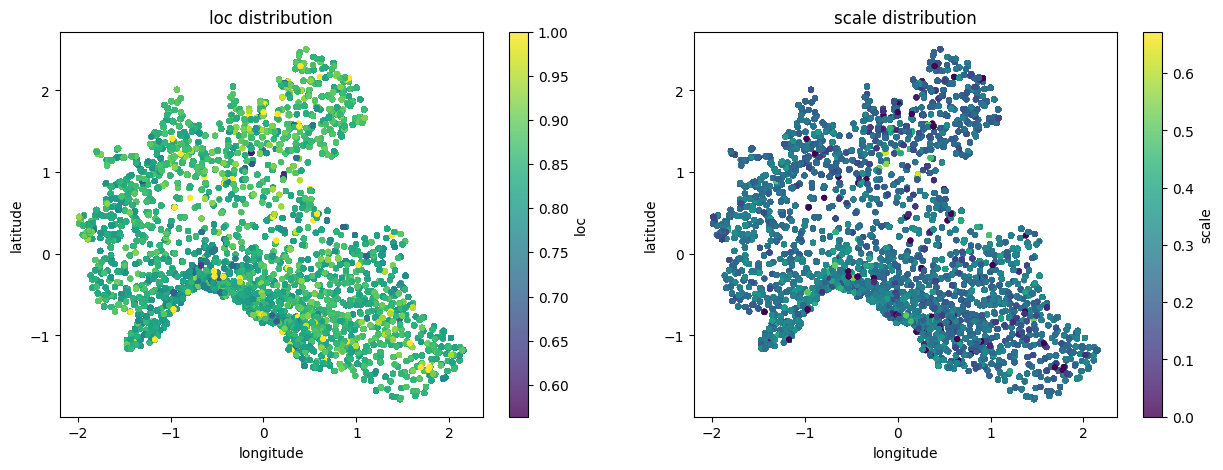

In [58]:
util.geographic_plot(train_df_std, 'loc', 'scale')

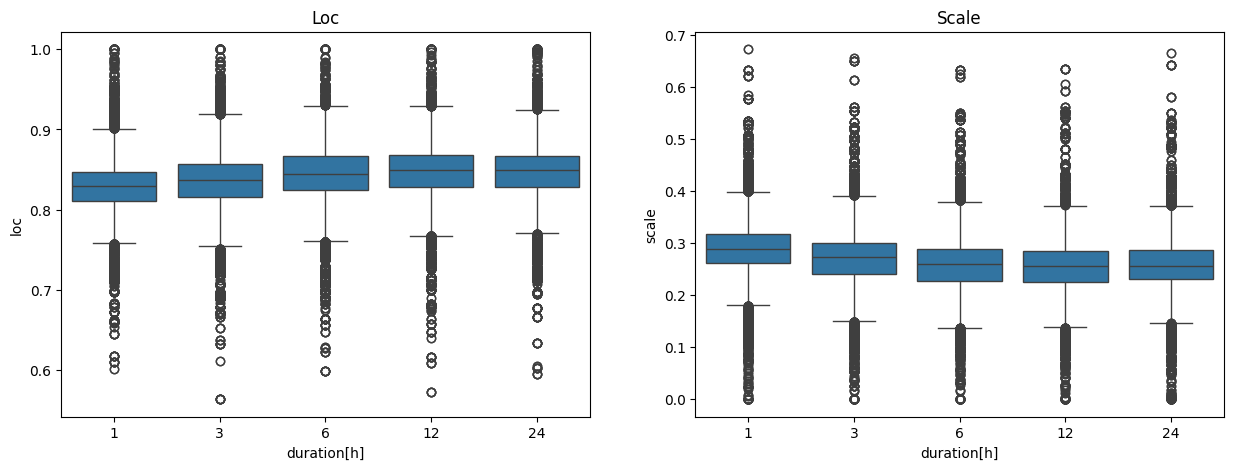

In [59]:
#boxplot of loc and scale
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(x='duration[h]', y='loc', data=train_df_std, ax=ax[0])
ax[0].set_title('Loc')

sns.boxplot(x='duration[h]', y='scale', data=train_df_std, ax=ax[1])
ax[1].set_title('Scale')

plt.show()

In [60]:
AMS_count = train_df_std.groupby(['ID','duration[h]'])['AMS'].count()
AMS_count = pd.DataFrame(AMS_count)
AMS_count.columns = ['count']
AMS_count['loc'] = train_df_std.groupby(['ID','duration[h]'])['loc'].mean() #prendo la media tanto lo stesso valore è ripetuto
AMS_count['scale'] = train_df_std.groupby(['ID','duration[h]'])['scale'].mean()

AMS_count.head(15)

count       loc     scale
ID   duration[h]                           
5001 1                2  0.890564  0.184415
     3                4  0.925308  0.129267
     6                4  0.932067  0.124795
     12               4  0.906658  0.175087
     24               4  0.859361  0.219803
5002 1               23  0.823918  0.287186
     3               23  0.783417  0.300108
     6               23  0.782840  0.333148
     12              23  0.804177  0.335036
     24              23  0.788515  0.355437
5003 1               55  0.820118  0.333625
     3               56  0.802589  0.378693
     6               56  0.806101  0.377994
     12              56  0.817565  0.370967
     24              56  0.818996  0.371627

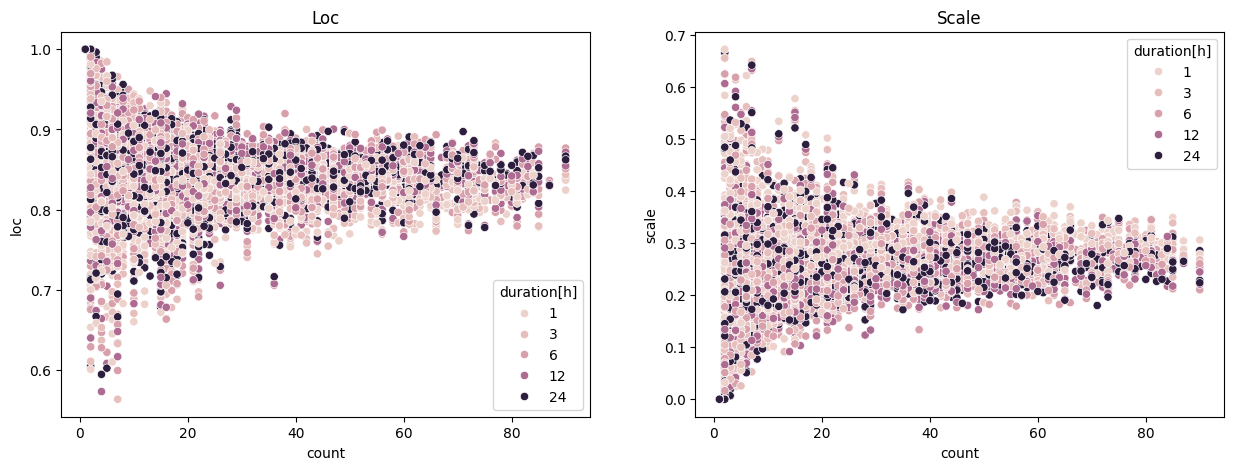

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='count', y='loc', data=AMS_count, ax=ax[0], hue='duration[h]')
ax[0].set_title('Loc')

sns.scatterplot(x='count', y='scale', data=AMS_count, ax=ax[1], hue='duration[h]')
ax[1].set_title('Scale')

plt.show()

### 1.3. Prepare data for training

In [62]:
# sort the dataframes by ID and then by duration
train_df_std = train_df_std.sort_values(by=['ID', 'duration[h]'])
val_df_std = val_df_std.sort_values(by=['ID', 'duration[h]'])
test_df_std = test_df_std.sort_values(by=['ID', 'duration[h]'])

# create a dict to store the indexes of same durations
durations_indexes_train = {}
for duration in DURATION:
    durations_indexes_train[duration] = train_df_std[train_df_std['duration[h]'] == duration].index

durations_indexes_val = {}
for duration in DURATION:
    durations_indexes_val[duration] = val_df_std[val_df_std['duration[h]'] == duration].index

durations_indexes_test = {}
for duration in DURATION:
    durations_indexes_test[duration] = test_df_std[test_df_std['duration[h]'] == duration].index

In [63]:
train_df_std.columns

Index(['ID', 'AMS', 'mean_IdD', 'loc', 'scale', 'duration[h]',
       'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')

In [64]:
# take all the columns except 'ID', 'AMS', 'mean_IdD' as input, and 'AMS' as output
columns = train_df_std.columns
input_columns = columns[5:]  
output_column = 'AMS'
parameters_columns = ['ID', 'duration[h]', 'loc', 'scale']
print('Input columns: ', input_columns)

Input columns:  Index(['duration[h]', 'HMerit_mean(m)', 'HMerit_stdev(m)', 'Slope_mean(deg)',
       'Slope_stdev(deg)', 'Aspect_mean(deg)', 'Aspect_stdev(deg)',
       'MinDistAdriaticC_(km)', 'OrogrAdri_mean (m)', 'OrogrAdri_stdev(m)',
       'OrogrAdri_max(m)', 'MinDistTirrenicC_(km)', 'OrograTirr_mean(m)',
       'OrograTirr_stdev(m)', 'OrograTirr_max(m)', 'MAP(mm)', 'MASnowP(mm)',
       'VarClimPT(mm)', 'VarClimSowP(mm)', 'X', 'Y'],
      dtype='object')


In [65]:
inputs_train = train_df_std[input_columns]
outputs_train = train_df_std[output_column]
parameters_train = train_df_std[parameters_columns]

inputs_val = val_df_std[input_columns]
outputs_val = val_df_std[output_column]
parameters_val = val_df_std[parameters_columns]

inputs_test = test_df_std[input_columns]
outputs_test = test_df_std[output_column]
parameters_test = test_df_std[parameters_columns]

In [66]:
#make ohe for duration

inputs_train = pd.get_dummies(inputs_train, columns=['duration[h]'])
inputs_val = pd.get_dummies(inputs_val, columns=['duration[h]'])
inputs_test = pd.get_dummies(inputs_test, columns=['duration[h]'])

for duration in DURATION:
    inputs_train['duration[h]_'+str(duration)] = inputs_train['duration[h]_'+str(duration)].astype(int)
    inputs_val['duration[h]_'+str(duration)] = inputs_val['duration[h]_'+str(duration)].astype(int)
    inputs_test['duration[h]_'+str(duration)] = inputs_test['duration[h]_'+str(duration)].astype(int)

inputs_train

,HMerit_mean(m),HMerit_stdev(m),Slope_mean(deg),Slope_stdev(deg),Aspect_mean(deg),Aspect_stdev(deg),MinDistAdriaticC_(km),OrogrAdri_mean (m),OrogrAdri_stdev(m),OrogrAdri_max(m),...,MASnowP(mm),VarClimPT(mm),VarClimSowP(mm),X,Y,duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,1,0,0,0,0
15,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,1,0,0,0,0
5,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
6,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
7,1.491097,0.251105,0.104265,-0.433165,2.356325,0.207127,-0.602938,0.327227,0.547504,0.637867,...,4.627821,1.780453,4.585390,0.512238,-0.713267,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233201,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233202,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233203,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1
233204,1.385034,0.772005,0.693361,1.147691,-0.492610,0.078161,1.879655,0.615505,1.600197,1.960265,...,1.500728,0.805394,1.653221,-1.793283,1.246819,0,0,0,0,1


In [67]:
#MAP
inputs_train_map = inputs_train[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_val_map = inputs_val[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]
inputs_test_map = inputs_test[['MAP(mm)','duration[h]_1','duration[h]_3','duration[h]_6','duration[h]_12','duration[h]_24']]

inputs_train_map

,MAP(mm),duration[h]_1,duration[h]_3,duration[h]_6,duration[h]_12,duration[h]_24
0,2.169919,1,0,0,0,0
15,2.169919,1,0,0,0,0
5,2.169919,0,1,0,0,0
6,2.169919,0,1,0,0,0
7,2.169919,0,1,0,0,0
...,...,...,...,...,...,...
233201,-0.149450,0,0,0,0,1
233202,-0.149450,0,0,0,0,1
233203,-0.149450,0,0,0,0,1
233204,-0.149450,0,0,0,0,1


In [68]:
#PCA
inputs_train_pca = util.make_pca(inputs_train, 5)
inputs_val_pca = util.make_pca(inputs_val, 5)
inputs_test_pca = util.make_pca(inputs_test, 5)

inputs_train_pca


,0,1,2,3,4
0,4.026139,-0.292017,-1.023797,5.180254,0.373481
1,4.026139,-0.292017,-1.023797,5.180254,0.373481
2,4.026145,-0.292061,-1.023847,5.180427,0.373517
3,4.026145,-0.292061,-1.023847,5.180427,0.373517
4,4.026145,-0.292061,-1.023847,5.180427,0.373517
...,...,...,...,...,...
233213,5.923551,1.971400,2.285806,-0.279598,0.049575
233214,5.923551,1.971400,2.285806,-0.279598,0.049575
233215,5.923551,1.971400,2.285806,-0.279598,0.049575
233216,5.923551,1.971400,2.285806,-0.279598,0.049575


## 2. Model definition

#### 2.1 Base model

In [69]:
def build_nn_gumbel_model(input_shape, hidden):
    model_in = keras.Input(shape=input_shape, dtype='float64')
    x = model_in
    
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    
    mu_logsig = layers.Dense(2, activation='linear')(x)

    lf = lambda t: tfp.distributions.Gumbel(loc=t[:, :1], scale=(1e-6)+tf.math.exp(t[:, 1:]))
    model_out = tfp.layers.DistributionLambda(lf)(mu_logsig)
    model = keras.Model(model_in, model_out)
    
    return model

## 3. Training

### 3.1  MAP Training

In [70]:
y_train  = outputs_train.values
y_val = outputs_val.values
y_test = outputs_test.values

In [71]:
# Parameters for the training
batch_size = 128
epochs = 90 
lr = 1e-3
patience = 30
loss_prof = lambda y_true, dist: -dist.log_prob(y_true)

Training the model with only MAP descriptor...
Epoch 1/90
1823/1823 [==============================] - 5s 2ms/step - loss: 0.3243 - val_loss: 0.2694
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3120 - val_loss: 0.2608
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3107 - val_loss: 0.2739
Epoch 4/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3100 - val_loss: 0.2603
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3085 - val_loss: 0.2742
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3087 - val_loss: 0.2638
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3075 - val_loss: 0.2620
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3077 - val_loss: 0.2587
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3076 - val_loss: 0.2580
Epoch 10/90
1823/1823 [============

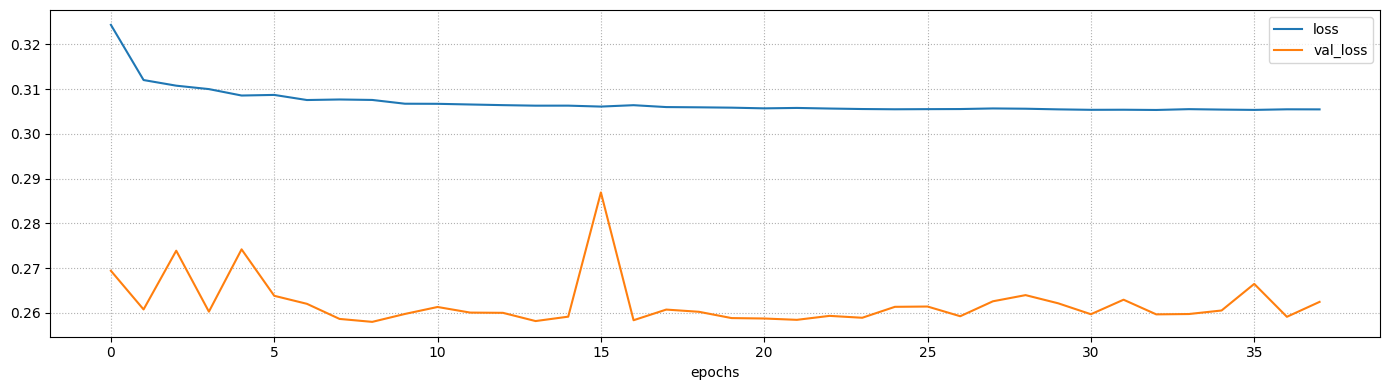

Final loss: 0.3055 (training), 0.2625 (validation)


In [72]:
X_train_map = inputs_train_map.values
X_val_map = inputs_val_map.values
X_test_map = inputs_test_map.values

print('Training the model with only MAP descriptor...')
map_model = build_nn_gumbel_model(input_shape=(X_train_map.shape[1],), hidden=[256,128]) #[256,128]
history = util.train_nn_model(map_model, X_train_map, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_map, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.2 Full-model

Training the model with all morphoclimatic descriptors...
Epoch 1/90
1823/1823 [==============================] - 6s 2ms/step - loss: 0.3354 - val_loss: 0.4831
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3070 - val_loss: 0.3566
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3011 - val_loss: 0.4005
Epoch 4/90
1823/1823 [==============================] - 5s 3ms/step - loss: 0.3001 - val_loss: 0.2898
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2965 - val_loss: 0.3224
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2953 - val_loss: 0.2900
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.2938 - val_loss: 0.2883
Epoch 8/90
1823/1823 [==============================] - 5s 3ms/step - loss: 0.2928 - val_loss: 0.2835
Epoch 9/90
1823/1823 [==============================] - 5s 3ms/step - loss: 0.2916 - val_loss: 0.3012
Epoch 10/90
1823/1823 [=

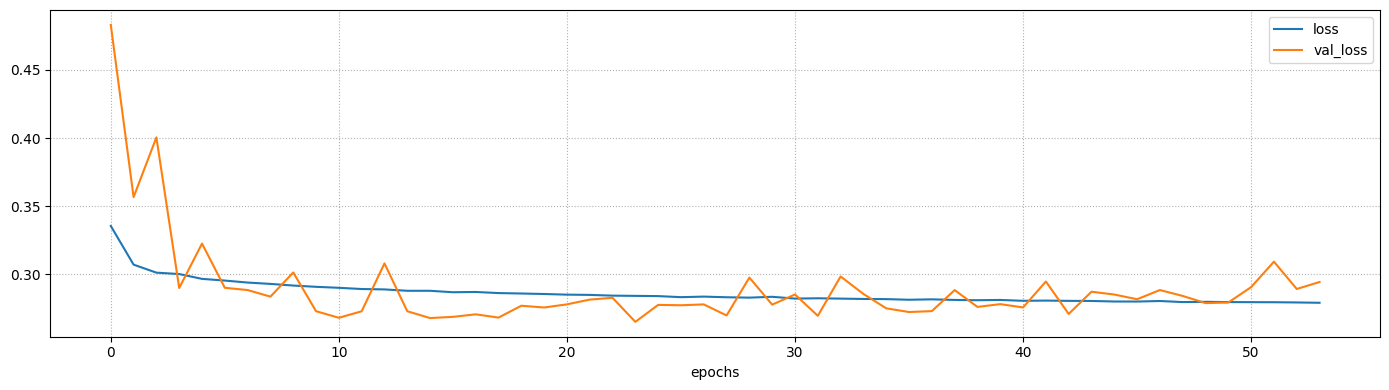

Final loss: 0.2790 (training), 0.2942 (validation)


In [73]:
X_train = inputs_train.values
X_val = inputs_val.values
X_test = inputs_test.values

print('Training the model with all morphoclimatic descriptors...')
full_model = build_nn_gumbel_model(input_shape=(X_train.shape[1],), hidden=[256,128]) #[256,128]
history = util.train_nn_model(full_model, X_train, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val, y_val))
util.plot_training_history(history, figsize=(14, 4))

### 3.3 PCA-model

Training the model with the PCA of the morphoclimatic descriptors...


Epoch 1/90
1823/1823 [==============================] - 5s 2ms/step - loss: 0.3807 - val_loss: 0.4034
Epoch 2/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3123 - val_loss: 0.3018
Epoch 3/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3082 - val_loss: 0.3487
Epoch 4/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3087 - val_loss: 0.3772
Epoch 5/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3060 - val_loss: 0.4210
Epoch 6/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3053 - val_loss: 0.3050
Epoch 7/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3040 - val_loss: 0.2729
Epoch 8/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3030 - val_loss: 0.2722
Epoch 9/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.3019 - val_loss: 0.2743
Epoch 10/90
1823/1823 [==============================] - 4s 2ms/step - loss: 0.300

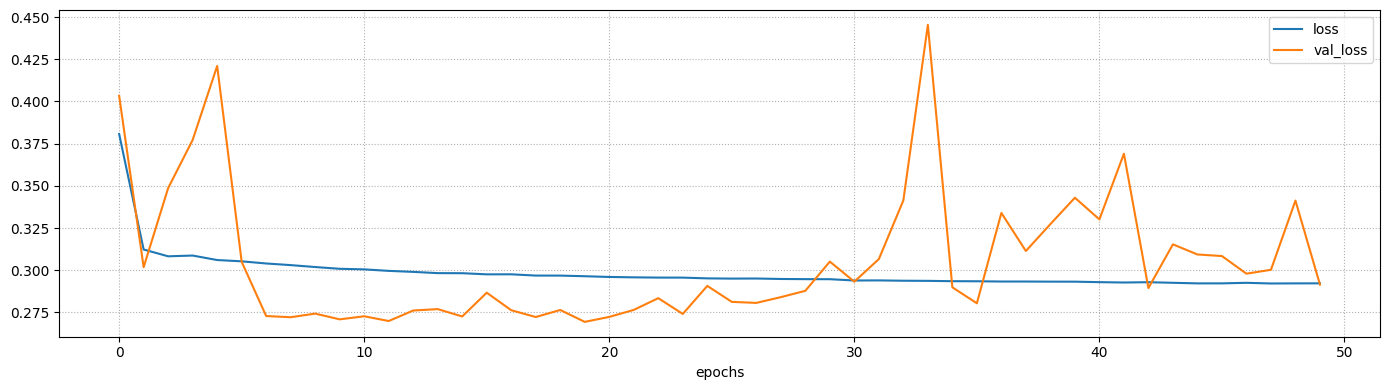

Final loss: 0.2922 (training), 0.2915 (validation)


In [74]:
X_train_pca = inputs_train_pca.values
X_val_pca = inputs_val_pca.values
X_test_pca = inputs_test_pca.values

print('Training the model with the PCA of the morphoclimatic descriptors...')
pca_model = build_nn_gumbel_model(input_shape=(X_train_pca.shape[1],), hidden=[256,128]) #[256,128]
history = util.train_nn_model(pca_model, X_train_pca, y_train, batch_size, loss_prof, lr, epochs, verbose=1, patience=patience, validation_data=(X_val_pca, y_val))
util.plot_training_history(history, figsize=(14, 4))

## 4. Evaluation

In [75]:
results = pd.DataFrame()

In [76]:
model_names = [ 'MAP', 'Full', 'PCA']
splits = ['Train', 'Validation', 'Test']
models = [map_model, full_model, pca_model]
X_values = {'MAP':[X_train_map, X_val_map, X_test_map], 'Full':[X_train, X_val, X_test], 'PCA':[X_train_pca, X_val_pca, X_test_pca]}
y_values = [y_train, y_val, y_test]
k = 0
for i, model_name in enumerate(model_names): 
    for j in range(3): #splits
        results[k] = util.evaluation(models[i], X_values[model_name][j], y_values[j], model_name, splits[j])
        k += 1

dist_train_map = map_model(X_train_map)
dist_val_map = map_model(X_val_map)
dist_test_map = map_model(X_test_map)

dist_train_full = full_model(X_train)
dist_val_full = full_model(X_val)
dist_test_full = full_model(X_test)

dist_train_pca = pca_model(X_train_pca)
dist_val_pca = pca_model(X_val_pca)
dist_test_pca = pca_model(X_test_pca)


Evaluating the MAP model on Train set...
Evaluating the MAP model on Validation set...
Evaluating the MAP model on Test set...
Evaluating the Full model on Train set...
Evaluating the Full model on Validation set...
Evaluating the Full model on Test set...
Evaluating the PCA model on Train set...
Evaluating the PCA model on Validation set...
Evaluating the PCA model on Test set...


In [77]:
results = results.T
results.columns=['Split', 'MAE', 'KS statistics']
display(results)

,Split,MAE,KS statistics
0,Train,0.384249,0.024003
1,Validation,0.370923,0.020684
2,Test,0.391822,0.026403
3,Train,0.38198,0.009429
4,Validation,0.37632,0.017249
5,Test,0.391712,0.013947
6,Train,0.381149,0.00966
7,Validation,0.374463,0.01613
8,Test,0.392281,0.017191


### 4.1 Distribution mean - confidence interval 

In [78]:
confidence = 0.99

Evaluation of MAP-model based on confidence intervals..


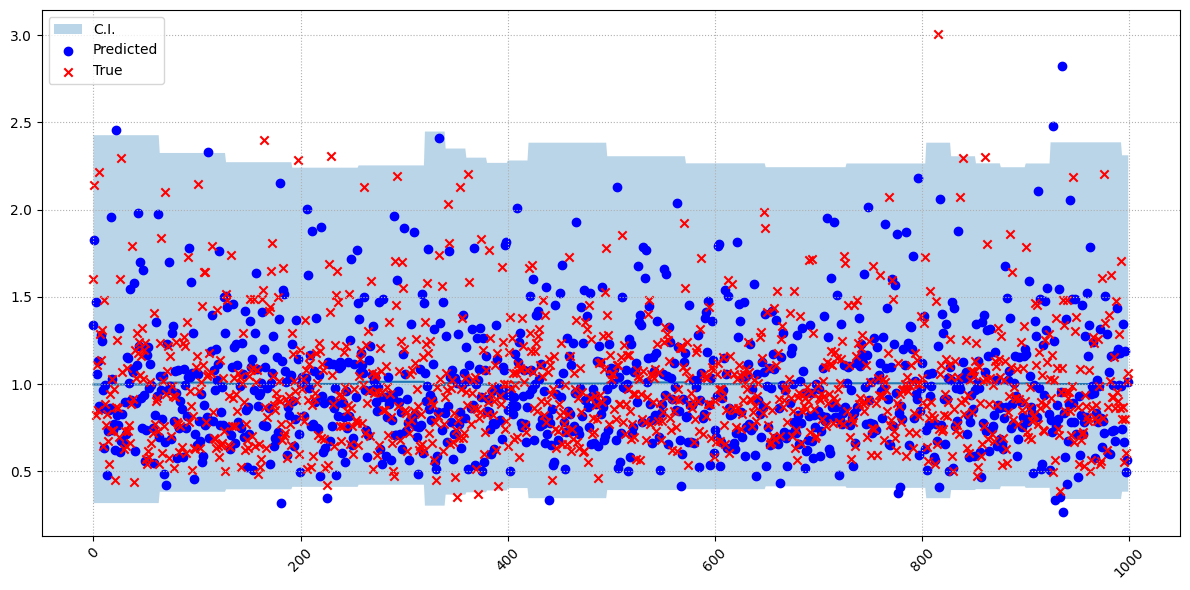

Percentage of values inside the 99% confidence interval: 98.18%


In [79]:
print('Evaluation of MAP-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_map, y_test, dist_test_map, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of Full-model based on confidence intervals..


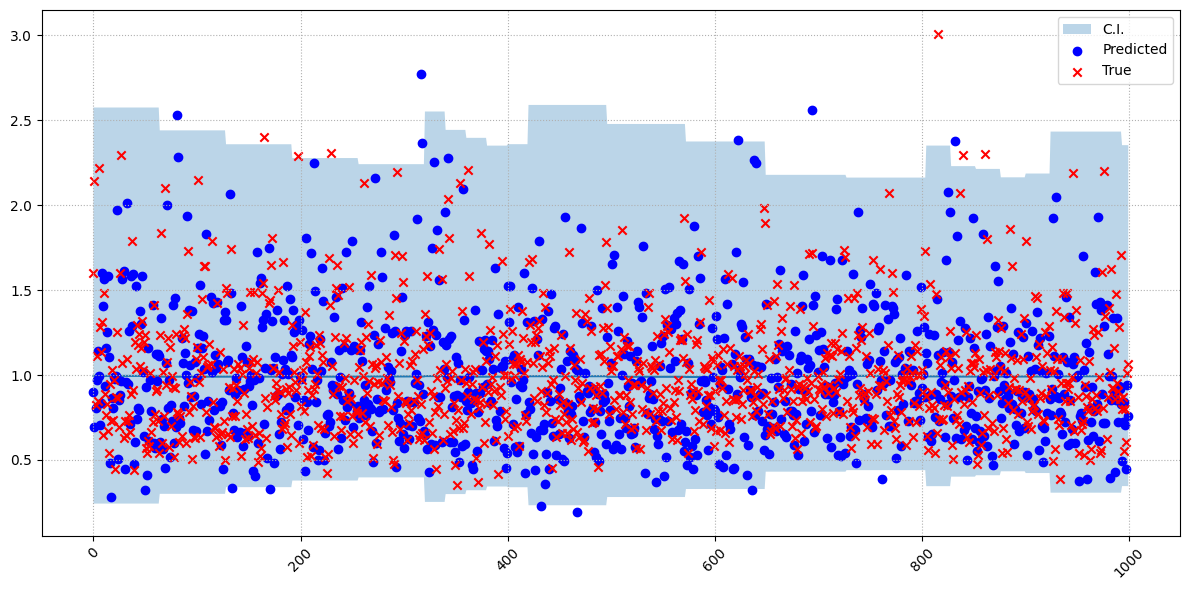

Percentage of values inside the 99% confidence interval: 98.11%


In [80]:
print('Evaluation of Full-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test, y_test, dist_test_full, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

Evaluation of PCA-model based on confidence intervals..


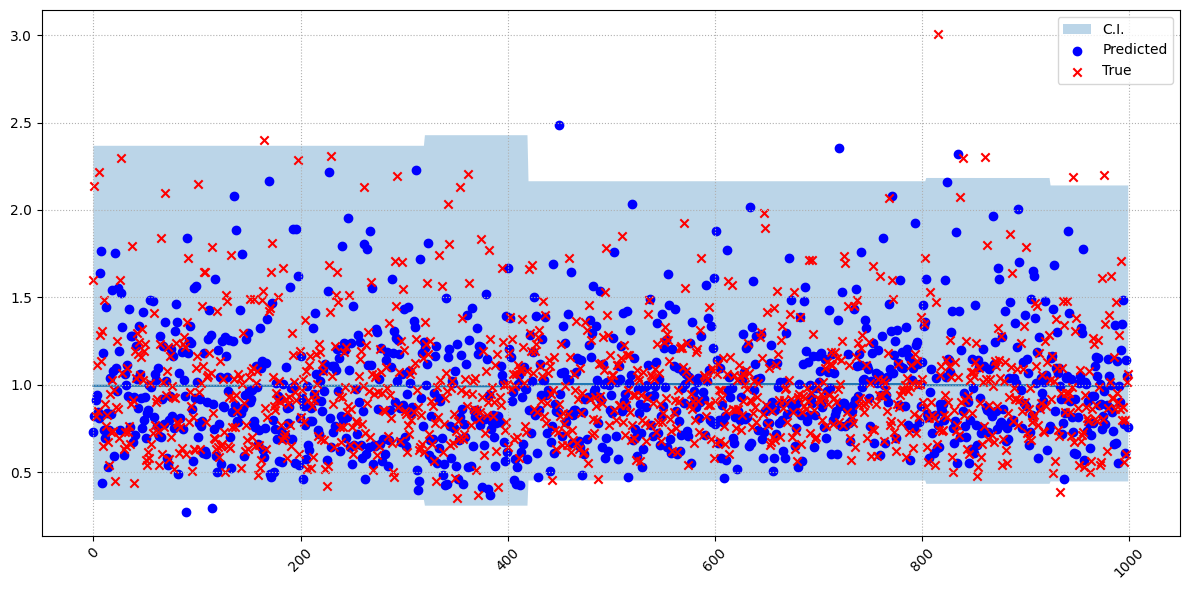

Percentage of values inside the 99% confidence interval: 97.76%


In [81]:
print('Evaluation of PCA-model based on confidence intervals..')
inside = util.percentage_in_ci(inputs_test_pca, y_test, dist_test_pca, confidence, distribution = 'gumbel', end = 1000)
print(f'Percentage of values inside the {confidence*100:.0f}% confidence interval: {inside:.2f}%')

## 5. Parameters

* Metrics on parameters from MAP-model

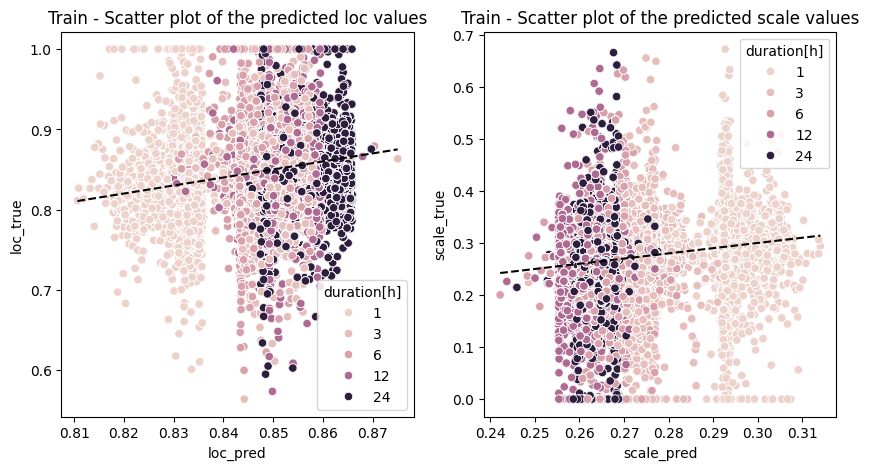

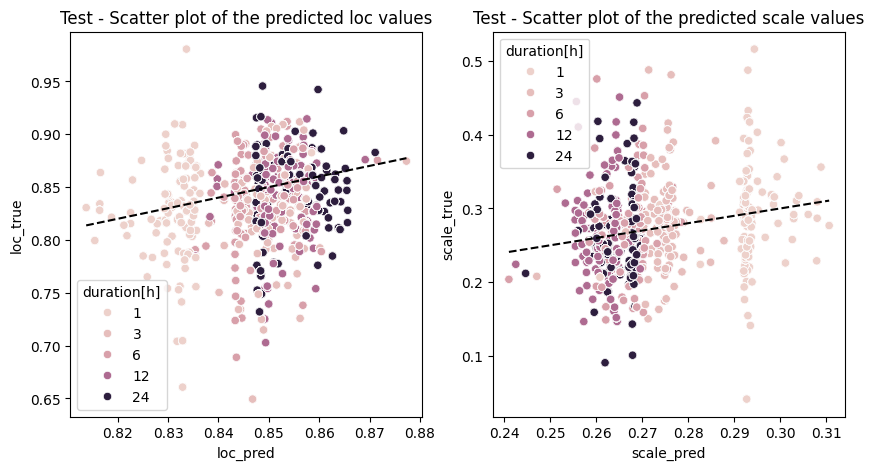

In [82]:
_ = util.parameters_metrics(dist_train_map, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_map, metrics_scale_map = util.parameters_metrics(dist_test_map, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [83]:
print('===============LOC PARAMETER===============')
display(metrics_loc_map)
print('===============SCALE PARAMETER==============')
metrics_scale_map

===============LOC PARAMETER===============


,global,1,3,6,12,24
biasr,-0.015624,-0.010576,-0.026614,-0.013371,-0.014036,-0.013523
rmse,0.036001,0.035112,0.040283,0.035748,0.034914,0.033580
pcc,0.206325,0.043605,0.109225,0.149798,0.093840,0.080638


===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.027339,-0.037217,-0.011668,-0.027107,-0.020034,-0.040684
rmse,0.047631,0.049279,0.047351,0.047481,0.047804,0.046187
pcc,0.263616,0.092073,0.058569,0.140293,0.091161,0.070415


* Metrics on parameters from Full-model

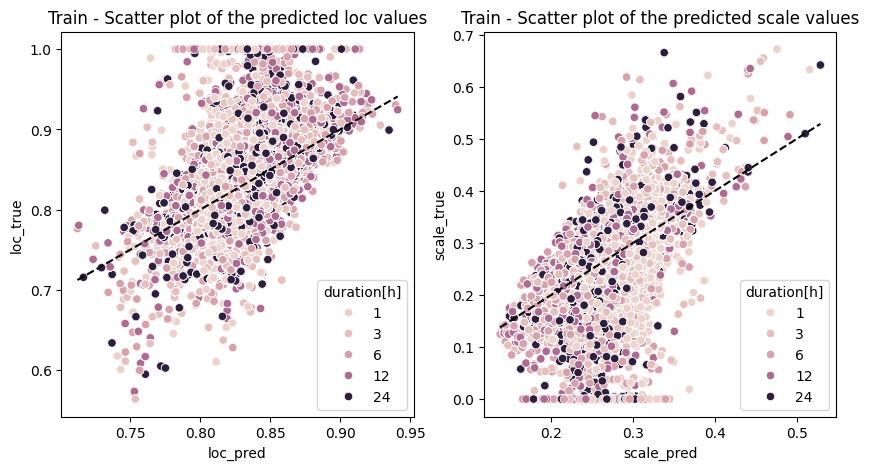

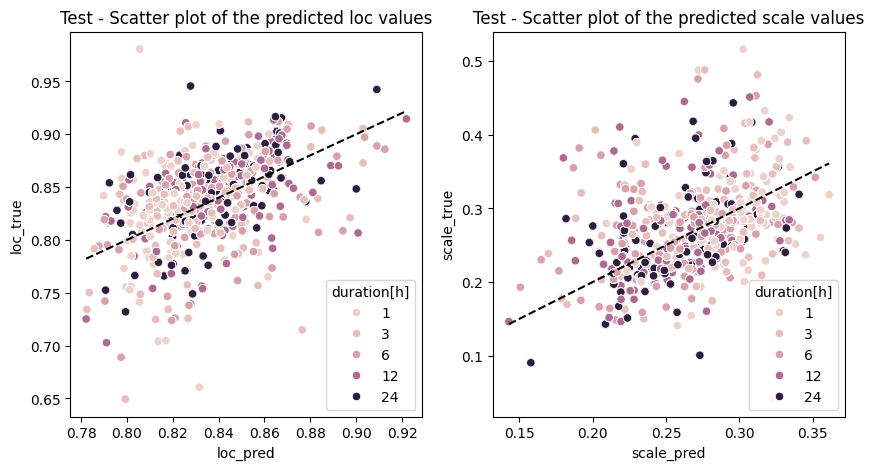

In [84]:
_ = util.parameters_metrics(dist_train_full, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_full, metrics_scale_full = util.parameters_metrics(dist_test_full, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [85]:
print('===============LOC PARAMETER===============')
metrics_loc_full
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============
===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.019154,-0.045173,-0.014054,-0.021453,0.003555,-0.018632
rmse,0.047527,0.051335,0.047429,0.048150,0.046971,0.043401
pcc,0.399888,0.236605,0.335053,0.324152,0.368831,0.421560


* Metrics on parameters from PCA-model

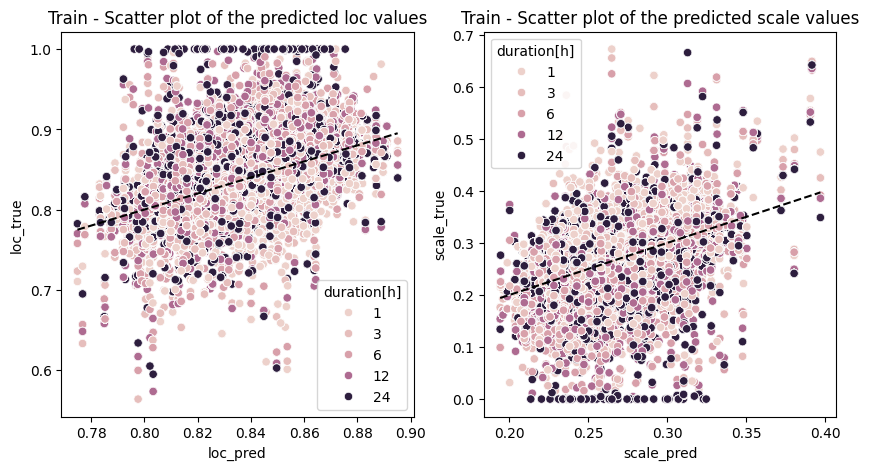

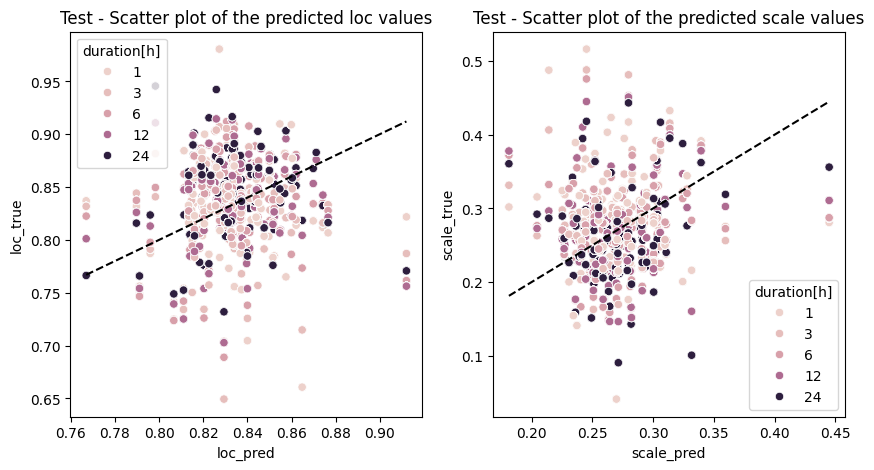

In [86]:
_ = util.parameters_metrics(dist_train_pca, parameters_train, distribution_name = 'gumbel', calculate_metrics = False, title='Train')
metrics_loc_pca, metrics_scale_pca = util.parameters_metrics(dist_test_pca, parameters_test, indexes = durations_indexes_test, distribution_name='gumbel', remove_outliers = False)

In [87]:
print('===============LOC PARAMETER===============')
metrics_loc_pca
print('===============SCALE PARAMETER==============')
metrics_scale_full

===============LOC PARAMETER===============
===============SCALE PARAMETER==============


,global,1,3,6,12,24
biasr,-0.019154,-0.045173,-0.014054,-0.021453,0.003555,-0.018632
rmse,0.047527,0.051335,0.047429,0.048150,0.046971,0.043401
pcc,0.399888,0.236605,0.335053,0.324152,0.368831,0.421560


### 5.1  Comparison between two samples extracted from "true" and predicted distribution of the same place 

True loc :  0.9066576729999072 Predicted  loc : 0.9201889
True scale :  0.1750865445495664 Predicted  scale : 0.1377708


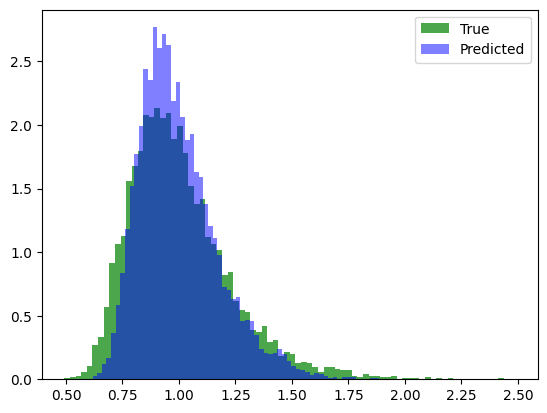

In [88]:
util.compare_samples(dist_train_full, "gumbel", parameters_train, index=9)
#util.compare_samples(dist_train_map, "gumbel", parameters_train, index=9)
#util.compare_samples(dist_train_pca, "gumbel", parameters_train, index=9)

## 6. Save results 


In [89]:
metrics_name = ['biasr', 'rmse', 'pcc']
models_name = ['map', 'full', 'pca']
models_metrics = [ metrics_scale_map, metrics_scale_full, metrics_scale_pca]

In [90]:
scale_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
scale_metrics

,biasr_map,biasr_full,biasr_pca,rmse_map,rmse_full,rmse_pca,pcc_map,pcc_full,pcc_pca
global,-0.027339,-0.019154,-0.024997,0.047631,0.047527,0.055401,0.263616,0.399888,0.163749
1,-0.037217,-0.045173,0.042016,0.049279,0.051335,0.063277,0.092073,0.236605,0.058224
3,-0.011668,-0.014054,0.000959,0.047351,0.047429,0.054022,0.058569,0.335053,0.168855
6,-0.027107,-0.021453,-0.045588,0.047481,0.048150,0.054468,0.140293,0.324152,0.161306
12,-0.020034,0.003555,-0.057670,0.047804,0.046971,0.053418,0.091161,0.368831,0.208312
24,-0.040684,-0.018632,-0.064782,0.046187,0.043401,0.051017,0.070415,0.421560,0.256827


In [91]:
models_metrics = [ metrics_loc_map, metrics_loc_full, metrics_loc_pca]
loc_metrics = util.get_global_results(metrics_name,models_name,models_metrics)
loc_metrics

,biasr_map,biasr_full,biasr_pca,rmse_map,rmse_full,rmse_pca,pcc_map,pcc_full,pcc_pca
global,-0.015624,0.003005,-0.000208,0.036001,0.031922,0.038417,0.206325,0.435664,0.118701
1,-0.010576,0.004506,-0.014549,0.035112,0.034211,0.040092,0.043605,0.251929,0.080420
3,-0.026614,-0.000870,-0.007215,0.040283,0.033591,0.038973,0.109225,0.349963,0.108757
6,-0.013371,0.002588,0.002724,0.035748,0.033256,0.038854,0.149798,0.371538,0.108079
12,-0.014036,0.001495,0.007437,0.034914,0.029990,0.037783,0.093840,0.468163,0.134622
24,-0.013523,0.007313,0.010583,0.033580,0.028116,0.036271,0.080638,0.526654,0.182235


In [92]:
#export as pkl file  loc and scale metrics
loc_metrics.to_pickle('results/loc_metrics.pkl')
scale_metrics.to_pickle('results/scale_metrics.pkl')
